### Libraries

In [1]:
from transformers import BertTokenizer, BertModel
import torch
from umap import UMAP
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import numpy as np

c:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\.venv\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotat

### Corpus embedding

In [10]:
def tokenizeCorpus(corpus, model=BertModel.from_pretrained('bert-base-uncased', 
                                                           output_hidden_states=True), 
                           tokenizer = BertTokenizer.from_pretrained('bert-base-uncased'), 
                           model_input_size=512):
    def flatten(l):
        return [item for sublist in l for item in sublist]
    input_size = model_input_size - 1
    corpusWords = corpus.split(" ")
    splited = [" ".join(corpusWords[i:i+input_size]) for i in range(0, len(corpusWords), input_size)]

    input_ids = []
    attention_masks = []
    for sentence in splited:
        encoded = tokenizer.encode_plus(sentence, 
                                        add_special_tokens=True,
                                        max_length=input_size+1,
                                        padding="max_length",
                                        return_attention_mask=True,
                                        return_tensors='pt',
                                        truncation=True)
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    #inputs_ids = torch.Tensor(len(input_ids),1, max_len+1)
    #torch.cat(input_ids, out=inputs_ids)
    inputs_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    temp = flatten([batch.tolist() for batch in input_ids])
    labels = np.array(temp)
    labels = labels.reshape((labels.shape[0]*labels.shape[1]))
    labels = tokenizer.convert_ids_to_tokens(labels)
    with torch.no_grad():
        output = model(inputs_ids, attention_mask=attention_masks)
    return output, labels

def vectorizeCorpus(model_output, allStates=True):
    if allStates==True:
        hidden_states = model_output.hidden_states
    else:
        hidden_states = [model_output.last_hidden_state]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = token_embeddings.permute(1,2,0,3)
    embs = []
    for batch in token_embeddings:
        for token in batch:
            emb = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
            embs.append(emb)
    return embs

def visualizeCorpus(embs, labels, dimension=2):
    formated_embs = [token.tolist() for token in embs]
    formated_embs = np.array(formated_embs)
    token_indexes = [i for i in range(len(labels)) if labels[i] != "[PAD]" and labels[i] != "[CLS]" and labels[i] != "[SEP]"]
    
    if dimension == 2: 
        umap2D = UMAP(n_components=2, init='random', random_state=0)
        proj2D = umap2D.fit_transform(formated_embs).T

        temp = []
        for dim in proj2D:
            temp.append([dim[j] for j in range(len(dim)) if j in token_indexes])
        proj2D = temp
        del temp

        labels = [labels[k] for k in range(len(labels)) if k in token_indexes]

        x = proj2D[0]
        y = proj2D[1]

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.scatter(x, y)
        for i, txt in enumerate(labels):
            ax.annotate(txt, (x[i], y[i]))
        
        plt.tight_layout()

    elif dimension == 3:
        
        umap3D = UMAP(n_components=3, init='random', random_state=0)
        proj3D = umap3D.fit_transform(formated_embs).T

        data = {"x": proj3D[0],
                "y": proj3D[1],
                "z": proj3D[2], 
                "labels": labels}
        
        for k in data.keys():
            data[k] = [data[k][i] for i in range(len(data[k])) if i in token_indexes]

        traces = []
        for i in range(len(data['x'])):
            trace = go.Scatter3d(
                x=[data['x'][i]],
                y=[data['y'][i]],
                z=[data['z'][i]],
                mode='markers',
                marker=dict(size=6),
                text=[data['labels'][i]],
                name=data['labels'][i]
            )
            traces.append(trace)

        layout = go.Layout(
            title='3D Scatter Plot',
            scene=dict(
                xaxis=dict(title='X'),
                yaxis=dict(title='Y'),
                zaxis=dict(title='Z')
            )
        )
        fig = go.Figure(data=traces, layout=layout)
        fig.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

corpus = "Wikipedia is a multilingual, free, online encyclopedia written and maintained by a community of volunteers, known as Wikipedians, through open collaboration and using a wiki-based editing system called MediaWiki. Wikipedia is the largest and most-read reference work in history. It is consistently one of the 10 most popular websites ranked by Similarweb and formerly Alexa; as of 2023, Wikipedia was ranked the 5th most popular site in the world according to Semrush. It is hosted by the Wikimedia Foundation, an American non-profit organization funded mainly through donations."
delimiter="."
print(corpus)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Wikipedia is a multilingual, free, online encyclopedia written and maintained by a community of volunteers, known as Wikipedians, through open collaboration and using a wiki-based editing system called MediaWiki. Wikipedia is the largest and most-read reference work in history. It is consistently one of the 10 most popular websites ranked by Similarweb and formerly Alexa; as of 2023, Wikipedia was ranked the 5th most popular site in the world according to Semrush. It is hosted by the Wikimedia Foundation, an American non-profit organization funded mainly through donations.


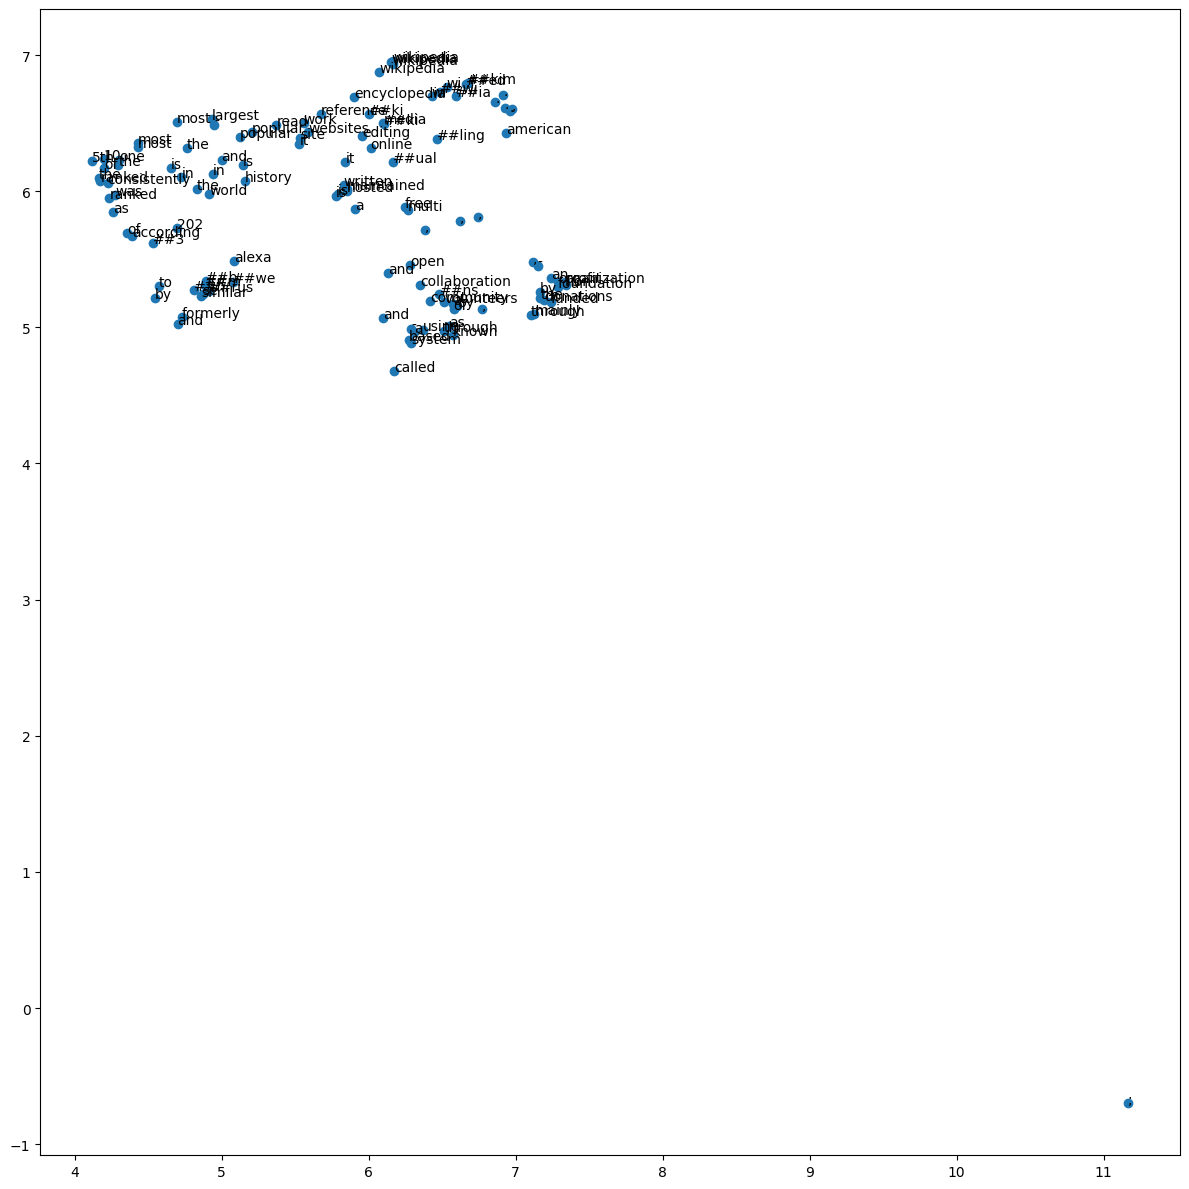

In [11]:
o, l = tokenizeCorpus(corpus)
v = vectorizeCorpus(o)
visualizeCorpus(v, l)